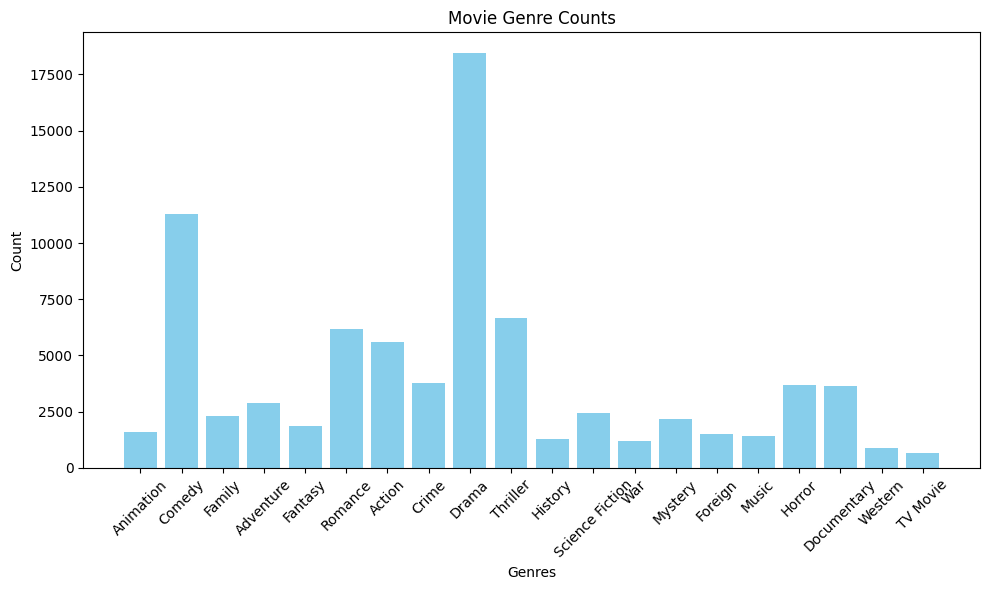

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Read the CSV file using a pipe delimiter.
csv_file = '/Users/kumarsatyam/python/basicsofai/project/bigdataset/archive/filtered_movies.csv'
data = pd.read_csv(csv_file, delimiter='|')

# Process the Genre column: split and strip the genre names.
all_genres = data['Genre'].dropna().apply(lambda x: [genre.strip() for genre in x.split(',')])
genre_list = [genre for sublist in all_genres for genre in sublist]

# Count occurrences of each genre.
genre_counts = Counter(genre_list)

# Prepare data for plotting.
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Movie Genre Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

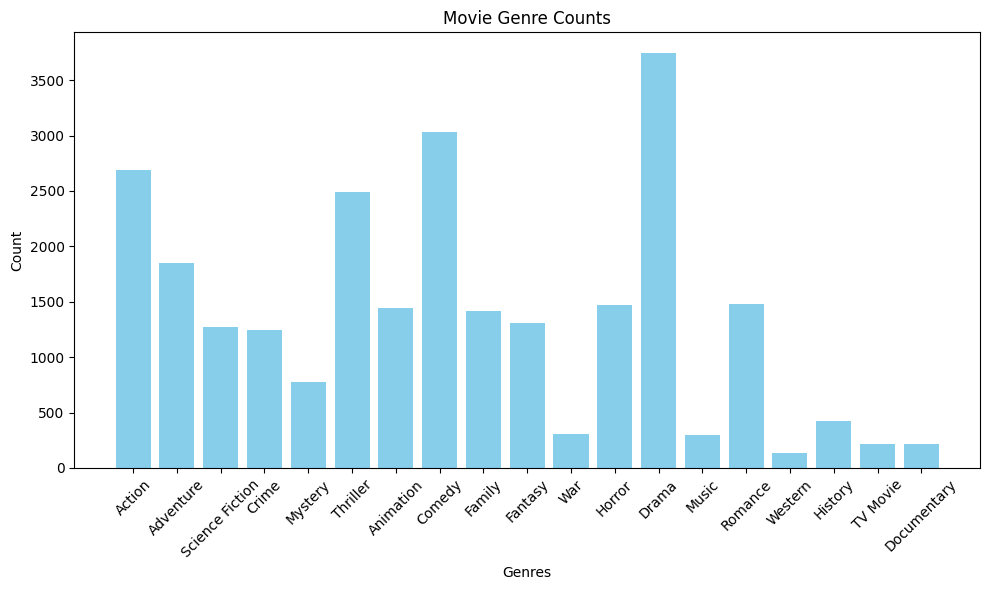

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Read the CSV file using a pipe delimiter.
csv_file = '/Users/kumarsatyam/python/basicsofai/project/mymoviedb_pipe.csv'
data = pd.read_csv(csv_file, delimiter='|')

# Process the Genre column: split and strip the genre names.
all_genres = data['Genre'].dropna().apply(lambda x: [genre.strip() for genre in x.split(',')])
genre_list = [genre for sublist in all_genres for genre in sublist]

# Count occurrences of each genre.
genre_counts = Counter(genre_list)

# Prepare data for plotting.
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Movie Genre Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import torch
from PIL import Image
import requests
from io import BytesIO
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

# Import necessary function from your workspace
from predict import predict_genre

# Load the dataset
df = pd.read_csv("/Users/kumarsatyam/python/basicsofai/project/bigdataset/archive/filtered_movies.csv", sep='|')

# Take a 10% random sample of the dataset
df_sample = df.sample(frac=0.1, random_state=42)

# Lists to store ground truth and predicted labels
true_labels = []
pred_labels = []

print("Running predictions on 10% sample of dataset...")
for idx, row in df_sample.iterrows():
    overview = row["Overview"]
    poster_url = row["Poster_Url"]
    
    # Get the predicted genres using your predict_genre function
    preds = predict_genre(overview, poster_url)
    
    # Get ground truth genres, handling missing or non-string values
    true = [g.strip() for g in row["Genre"].split(",")] if isinstance(row["Genre"], str) else []
    
    true_labels.append(true)
    pred_labels.append(preds)

# Load checkpoint to initialize the MultiLabelBinarizer with proper classes
checkpoint = torch.load(
    "multimodal_genre_classifier.pth",
    map_location=torch.device('mps' if torch.backends.mps.is_available() else 'cpu'),
    weights_only=False
)
mlb = MultiLabelBinarizer()
mlb.fit([checkpoint['mlb_classes']])  # Initialize mlb with saved genres

# Transform lists of genres to binary indicator arrays
y_true = mlb.transform(true_labels)
y_pred = mlb.transform(pred_labels)

# Compute multilabel confusion matrix for each genre
conf_matrix = multilabel_confusion_matrix(y_true, y_pred, labels=range(len(mlb.classes_)))
print("Multilabel Confusion Matrices:")
for i, cm in enumerate(conf_matrix):
    print(f"Genre: {mlb.classes_[i]}\n{cm}\n")

# Compute overall accuracy per sample
sample_accuracy = accuracy_score(y_true, y_pred)
print(f"Overall sample accuracy: {sample_accuracy:.2%}")

# Compute the overall F1 score (micro averaged)
overall_f1 = f1_score(y_true, y_pred, average='micro')
print(f"Overall F1 Score (micro avg): {overall_f1:.4f}")

Running predictions on 10% sample of dataset...


/Users/kumarsatyam/python/basicsofai/project/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kumarsatyam/python/basicsofai/project/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/kumarsatyam/python/basicsofai/project/.venv/lib/python3.9/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (130787001 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/kumarsatyam/python/basicsofai/project/.venv/lib

Multilabel Confusion Matrices:
Genre: Action
[[3330   59]
 [ 356  235]]

Genre: Adventure
[[3683   20]
 [ 246   31]]

Genre: Animation
[[3782   25]
 [  93   80]]

Genre: Comedy
[[2583  287]
 [ 396  714]]

Genre: Crime
[[3490  114]
 [ 232  144]]

Genre: Documentary
[[3561   51]
 [ 107  261]]

Genre: Drama
[[1685  489]
 [ 519 1287]]

Genre: Family
[[3711   45]
 [ 140   84]]

Genre: Fantasy
[[3777    9]
 [ 174   20]]

Genre: Foreign
[[3831    0]
 [ 149    0]]

Genre: History
[[3847    6]
 [ 114   13]]

Genre: Horror
[[3574   59]
 [ 145  202]]

Genre: Music
[[3810   22]
 [ 107   41]]

Genre: Mystery
[[3753   15]
 [ 199   13]]

Genre: Romance
[[3180  204]
 [ 326  270]]

Genre: Science Fiction
[[3701   23]
 [ 125  131]]

Genre: TV Movie
[[3905    0]
 [  75    0]]

Genre: Thriller
[[3049  278]
 [ 278  375]]

Genre: Unknown
[[3980    0]
 [   0    0]]

Genre: War
[[3841   17]
 [  88   34]]

Genre: Western
[[3885    6]
 [  31   58]]

Overall sample accuracy: 26.16%
Overall F1 Score (micro avg): 

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2ForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load and Preprocess the Dataset
df = pd.read_csv('filtered_movies.csv', delimiter='|')

# Handle missing values in the Genre column
df['Genre'] = df['Genre'].fillna('')  # Replace NaN with empty string

# Clean the Genre column (split multi-label genres)
df['Genre'] = df['Genre'].apply(lambda x: [g.strip() for g in x.split(',')] if x else [])

# Select top genres based on the histogram
top_genres = ['Drama', 'Comedy', 'Action', 'Thriller', 'Adventure', 'Romance', 'Crime', 'Science Fiction', 'Horror', 'Family','Documentary']

# Filter movies with at least one of the top genres
df['Genre'] = df['Genre'].apply(lambda x: [g for g in x if g in top_genres])
df = df[df['Genre'].map(len) > 0]  # Remove rows with no matching genres

# Multi-label encoding
mlb = MultiLabelBinarizer(classes=top_genres)
y = mlb.fit_transform(df['Genre'])

# Text data
X = df['Overview'].fillna('').values  # Also handle missing values in Overview

# Train-Test-Validation Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Step 2: Custom Dataset for PyTorch
class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer=None, max_len=128, is_bert_or_gpt=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_bert_or_gpt = is_bert_or_gpt

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        if self.is_bert_or_gpt:
            # For BERT or GPT
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.FloatTensor(label)
            }
        else:
            # For LSTM (we'll tokenize later in the model)
            return {
                'text': text,
                'labels': torch.FloatTensor(label)
            }

# Step 3: Define Models

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask=None):
        embedded = self.dropout(self.embedding(input_ids))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        dense_out = self.fc(hidden[-1])
        return self.sigmoid(dense_out)

# Step 4: Training and Evaluation Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, is_bert_or_gpt=False):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_labels = [], []

        for batch in train_loader:
            optimizer.zero_grad()
            if is_bert_or_gpt:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask).logits
            else:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss = total_train_loss / len(train_loader)
        train_acc = accuracy_score(np.array(train_labels), np.array(train_preds))
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                if is_bert_or_gpt:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask).logits
                else:
                    input_ids = batch['input_ids'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids)

                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(np.array(val_labels), np.array(val_preds))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Convert lists to NumPy arrays before returning
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)

    return train_losses, val_losses, train_accuracies, val_accuracies, val_preds, val_labels

# Step 5: Evaluation and Visualization
def evaluate_and_visualize(model_name, val_preds, val_labels, train_losses, val_losses, train_accuracies, val_accuracies):
    # F1 Score and Classification Report
    f1 = f1_score(val_labels, val_preds, average='micro')
    print(f"\n{model_name} - F1 Score (Micro): {f1:.4f}")
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(val_labels, val_preds, target_names=top_genres))

    # Confusion Matrix (for each genre)
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    for i, genre in enumerate(top_genres):
        cm = confusion_matrix(val_labels[:, i], val_preds[:, i])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'CM: {genre}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    plt.tight_layout()
    plt.show()

    # Training and Validation Loss/Accuracy Plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Step 6: Run for Each Model

# 6.1: LSTM Model
# Tokenization for LSTM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Using BERT tokenizer for simplicity
def tokenize_for_lstm(texts, tokenizer, max_len=128):
    input_ids = []
    for text in texts:
        encoding = tokenizer(text, max_length=max_len, padding='max_length', truncation=True, return_tensors='pt')
        input_ids.append(encoding['input_ids'].flatten())
    return torch.stack(input_ids)

# Prepare data for LSTM
train_input_ids = tokenize_for_lstm(X_train, tokenizer).to(device)
val_input_ids = tokenize_for_lstm(X_val, tokenizer).to(device)
test_input_ids = tokenize_for_lstm(X_test, tokenizer).to(device)

class LSTMDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'labels': torch.FloatTensor(self.labels[idx])
        }

train_dataset_lstm = LSTMDataset(train_input_ids, y_train)
val_dataset_lstm = LSTMDataset(val_input_ids, y_val)
test_dataset_lstm = LSTMDataset(test_input_ids, y_test)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=32)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=32)

# Initialize LSTM Model
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256
output_dim = len(top_genres)
n_layers = 2
dropout = 0.5

lstm_model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization added

# Train LSTM
train_losses_lstm, val_losses_lstm, train_accuracies_lstm, val_accuracies_lstm, val_preds_lstm, val_labels_lstm = train_model(
    lstm_model, train_loader_lstm, val_loader_lstm, criterion, optimizer, num_epochs=5, device=device
)

# Evaluate LSTM
evaluate_and_visualize("LSTM", val_preds_lstm, val_labels_lstm, train_losses_lstm, val_losses_lstm, train_accuracies_lstm, val_accuracies_lstm)

# 6.2: BERT Model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset_bert = MovieDataset(X_train, y_train, bert_tokenizer, is_bert_or_gpt=True)
val_dataset_bert = MovieDataset(X_val, y_val, bert_tokenizer, is_bert_or_gpt=True)
test_dataset_bert = MovieDataset(X_test, y_test, bert_tokenizer, is_bert_or_gpt=True)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=16)

# Initialize BERT Model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(top_genres)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bert_model.parameters(), lr=2e-5, weight_decay=1e-4)  # L2 regularization added

# Train BERT
train_losses_bert, val_losses_bert, train_accuracies_bert, val_accuracies_bert, val_preds_bert, val_labels_bert = train_model(
    bert_model, train_loader_bert, val_loader_bert, criterion, optimizer, num_epochs=3, device=device, is_bert_or_gpt=True
)

# Evaluate BERT
evaluate_and_visualize("BERT", val_preds_bert, val_labels_bert, train_losses_bert, val_losses_bert, train_accuracies_bert, val_accuracies_bert)

# 6.3: GPT Model
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token  # GPT-2 doesn't have a pad token by default
train_dataset_gpt = MovieDataset(X_train, y_train, gpt_tokenizer, is_bert_or_gpt=True)
val_dataset_gpt = MovieDataset(X_val, y_val, gpt_tokenizer, is_bert_or_gpt=True)
test_dataset_gpt = MovieDataset(X_test, y_test, gpt_tokenizer, is_bert_or_gpt=True)

train_loader_gpt = DataLoader(train_dataset_gpt, batch_size=16, shuffle=True)
val_loader_gpt = DataLoader(val_dataset_gpt, batch_size=16)
test_loader_gpt = DataLoader(test_dataset_gpt, batch_size=16)

# Initialize GPT Model
gpt_model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(top_genres)).to(device)
gpt_model.config.pad_token_id = gpt_tokenizer.pad_token_id
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(gpt_model.parameters(), lr=2e-5, weight_decay=1e-4)  # L2 regularization added

# Train GPT
train_losses_gpt, val_losses_gpt, train_accuracies_gpt, val_accuracies_gpt, val_preds_gpt, val_labels_gpt = train_model(
    gpt_model, train_loader_gpt, val_loader_gpt, criterion, optimizer, num_epochs=3, device=device, is_bert_or_gpt=True
)

# Evaluate GPT
evaluate_and_visualize("GPT", val_preds_gpt, val_labels_gpt, train_losses_gpt, val_losses_gpt, train_accuracies_gpt, val_accuracies_gpt)

FileNotFoundError: [Errno 2] No such file or directory: 'filtered_movies.csv'